In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as ss
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

In [132]:
data = pd.read_csv('../Datasets/Social_Network_Ads.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [133]:
data.head(3)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0


In [134]:
data['Purchased'].describe()

count    400.000000
mean       0.357500
std        0.479864
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Purchased, dtype: float64

In [135]:
x = data.iloc[:,[2, 3]].values
y = data.iloc[:,-1].values

x[:3]

array([[   19, 19000],
       [   35, 20000],
       [   26, 43000]], dtype=int64)

<AxesSubplot:xlabel='Purchased', ylabel='Age'>

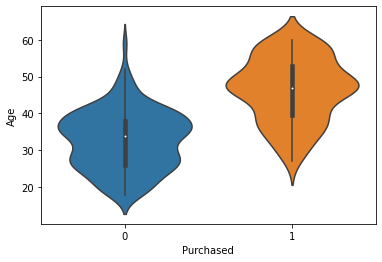

In [136]:
#Pregunta 1 
#Al ser Purchased nuestro target lo compararemos con las variables Age y EstimatedSalary
sns.violinplot(x='Purchased',y='Age',data=data)

<AxesSubplot:xlabel='Purchased', ylabel='EstimatedSalary'>

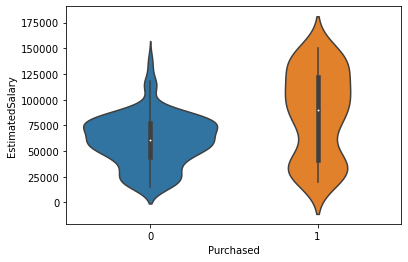

In [137]:
sns.violinplot(x='Purchased',y='EstimatedSalary',data=data)

In [138]:
#En base a los graficos podemos concluir que ambas variables son utiles para el analisis debido a que su mediana no es la misma 
#Adicionalmente respecto a la grafica analizando la edad podemos observar que solo presenta una moda mientras que en la 
#grafica del salario estimado se puede apreciar una distribucion mas bimodal

In [139]:
#Pregunta 2
x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN = train_test_split(x, y, test_size = 0.20, random_state = 0)
x_train_KNN[:3]

x_train_KNN = StandardScaler().fit_transform(x_train_KNN)
x_test_KNN = StandardScaler().fit_transform(x_test_KNN)

In [140]:
cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=5), x_train_KNN, y_train_KNN, cv=5)
print(cv_scores)

[0.84375  0.859375 0.90625  0.90625  0.984375]


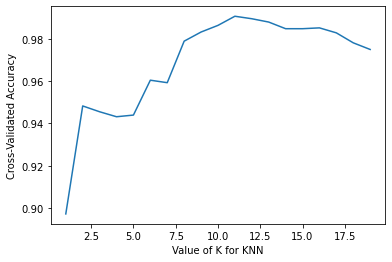

Best K = 11


In [141]:
k_range = range(1, 20)
k_scores = []

best_K = 0
current_auc = 0

for k in k_range:
    
    knn = KNeighborsClassifier(n_neighbors=k).fit(x_train_KNN, y_train_KNN)
    y_pred_KNN = knn.predict(x_test_KNN)
    y_pred_prob = knn.predict_proba(x_test_KNN)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_KNN, y_pred_prob[:,1])
    roc_auc_KNN = auc(false_positive_rate, true_positive_rate)
    k_scores.append(roc_auc_KNN)

    if roc_auc_KNN > current_auc:
        current_auc = roc_auc_KNN
        best_K = k
    
    
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

print("Best K = " + str(best_K))

#Luego de comparar el AUC obtenido al utilizar valores de K de 1 al 20 podemos concluir que el mejor K es el 11
#el cual cuenta con un AUC de 0.99

In [142]:
classifier_KNN = KNeighborsClassifier(n_neighbors=11).fit(x_train_KNN, y_train_KNN)
y_pred_KNN = classifier_KNN.predict(x_test_KNN)
confusion_matrix(y_test_KNN, y_pred_KNN)

array([[55,  3],
       [ 1, 21]], dtype=int64)

Confusion matrix, without normalization
[[55  3]
 [ 1 21]]
Normalized confusion matrix
[[0.94827586 0.05172414]
 [0.04545455 0.95454545]]


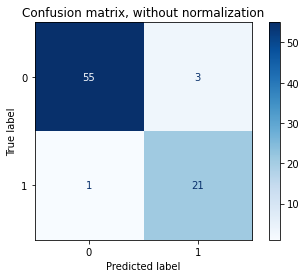

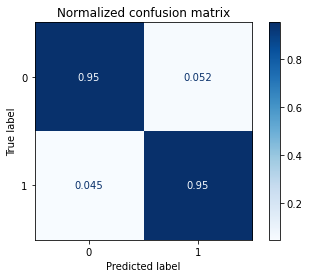

In [143]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier_KNN, x_test_KNN, y_test_KNN,
                                 #display_labels=y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

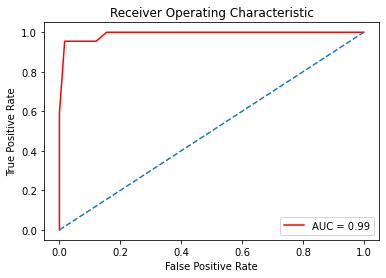

In [144]:
y_pred_prob = classifier_KNN.predict_proba(x_test_KNN)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_KNN, y_pred_prob[:,1])
roc_auc_KNN = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc_KNN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [145]:
#Pregunta 3
#Agregamos los modelos de Naive Bayes, Decision Tree y Redes Neuronales para compararlo con lo trabajado
x_train_DT, x_test_DT, y_train_DT, y_test_DT = train_test_split(x, y, test_size = 0.20, random_state = 0)

param_grid = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid = GridSearchCV(tree.DecisionTreeClassifier(),param_grid,refit=True,verbose=2,cv=5)
grid.fit(x_train_DT,y_train_DT)
classifier_DT = tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf=5).fit(x_train_DT, y_train_DT)
y_pred_DT = classifier_DT.predict(x_test_DT)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=10 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=10, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=10 ................
[CV] . criterio

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] criterion=entropy, max_depth=2, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=100 ............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=100, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=100 ............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=100, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=100 ............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=100, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=100 ............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=100, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=100 ............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=100, 

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished


In [146]:
y_pred_prob_DT = classifier_DT.predict_proba(x_test_DT)
false_positive_rate_DT, true_positive_rate_DT, thresholds_DT = roc_curve(y_test_DT, y_pred_prob_DT[:,1])
roc_auc_DT = auc(false_positive_rate_DT, true_positive_rate_DT)
roc_auc_DT

0.9494514106583072

In [147]:
x_train_NB, x_test_NB, y_train_NB, y_test_NB = train_test_split(x, y, test_size = 0.20, random_state = 0)

classifier_G = GaussianNB().fit(x_train_NB, y_train_NB)
y_pred_prob_NB = classifier_G.predict_proba(x_test_NB)
false_positive_rate_NB, true_positive_rate_NB, thresholds = roc_curve(y_test_NB, y_pred_prob_NB[:,1])
roc_auc_NB = auc(false_positive_rate_NB, true_positive_rate_NB)
roc_auc_NB

0.9843260188087775

In [148]:
x = data.iloc[:,[2, 3]].values
y = data.iloc[:,-1].values

x_train_RN, x_test_RN, y_train_RN, y_test_RN = train_test_split(x, y, test_size = 0.20, random_state = 0)

x_train_RN = StandardScaler().fit_transform(x_train_RN)
x_test_RN = StandardScaler().fit_transform(x_test_RN)

classifier_RN = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=500, alpha=0.0001,
                     solver='adam', random_state=21,tol=0.000000001)

param_grid = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

grid = GridSearchCV(MLPClassifier(max_iter=500),param_grid,refit=True,verbose=2,cv=5)
grid.fit(x_train_RN,y_train_RN)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, s

C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=   0.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=   0.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive,

C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, tota

C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, tota

C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), 

C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant,

C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=relu, alpha=0.0001,

C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.0001,

C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, total=   0.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, total=   0.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, total=   0.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, total=   0.8s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, tota

C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   0.8s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, total=   1.1s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=   0.8s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=   0.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=

C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=   0.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, total=   0.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd, total=   0.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd, total=   0.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 


C:\ProgramData\Anaconda3_delete\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, total=   0.3s


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.2min finished


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=500),
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             verbose=2)

In [149]:
classifier_RN = MLPClassifier(hidden_layer_sizes=(10,30,10),max_iter=500,alpha=0.05).fit(x_train_RN, y_train_RN)
y_pred_RN = classifier_RN.predict(x_test_RN)
y_pred_prob_RN = classifier_RN.predict_proba(x_test_RN)
false_positive_rate_RN, true_positive_rate_RN, thresholds_RN = roc_curve(y_test_RN, y_pred_prob_RN[:,1])
roc_auc_RN = auc(false_positive_rate_RN, true_positive_rate_RN)
roc_auc_RN

0.9694357366771159

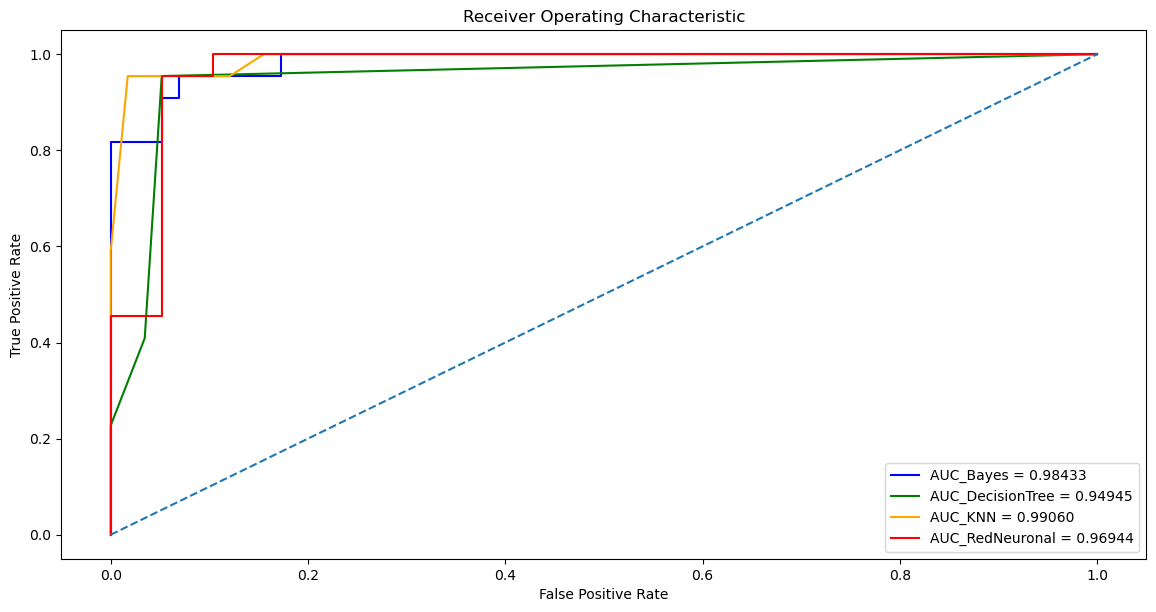

In [158]:
plt.figure(figsize=(14,7),dpi=100)
plt.title('Receiver Operating Characteristic')

plt.plot(false_positive_rate_NB,true_positive_rate_NB, color='blue',label = 'AUC_Bayes = %0.5f' % roc_auc_NB)
plt.plot(false_positive_rate_DT,true_positive_rate_DT, color='green',label = 'AUC_DecisionTree = %0.5f' % roc_auc_DT)
plt.plot(false_positive_rate,true_positive_rate, color='orange',label = 'AUC_KNN = %0.5f' % roc_auc_KNN)
plt.plot(false_positive_rate_RN,true_positive_rate_RN, color='red',label = 'AUC_RedNeuronal = %0.5f' % roc_auc_RN)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [151]:
#Luego de realizar los modelos de MachineLearning aprendidos en el curso podemos observar los diferentes valores de AUC
#con ellos llegamos a la conclusion que el modelo mas acertado seria el del KNN un con K de 11 debido a que obtiene un AUC
#de aproximadamente 99%